In [17]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [18]:
import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                      exception_only=False, running_compiled_code=False):
       etype, value, tb = sys.exc_info()
       return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [19]:
fname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_final'}.xlsx")
cname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_case'}.xlsx")
lname = os.path.join(os.path.dirname(os.getcwd()), 'xlsx_data', f"{'xlsx_#10_law'}.xlsx")

dff = pd.read_excel(fname, index_col=0)
dfc = pd.read_excel(cname, index_col=0)
dfl = pd.read_excel(lname, index_col=0)

df = pd.concat([dff[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex', 'text', 'y_sentence']], dfc[1:], dfl[1:]], axis=1).reindex(dff.index)
df = df.dropna(subset=['y_sentence'])
df = df[df['y_sentence'] < 481]

In [20]:
X = df.drop('y_sentence', axis=1)
y = df['y_sentence']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [22]:
X1_train = X_train[dfc.columns[1:]]
X1_test = X_test[dfc.columns[1:]]

X2_train = X_train[dfl.columns[1:]]
X2_test = X_test[dfl.columns[1:]]

X4_train =  X_train[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]
X4_test =  X_test[['h1_age', 'h1_sex', 'h2_age', 'h2_sex', 'h3_age', 'h3_sex']]

In [23]:
X3_train = list(X_train["text"])
X3_test = list(X_test["text"])

max_features = 30000
sequence_length = 128

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(X3_train)

X3_train = tokenizer.texts_to_sequences(X3_train)
X3_test = tokenizer.texts_to_sequences(X3_test)

X3_train = tf.keras.preprocessing.sequence.pad_sequences(X3_train, sequence_length)
X3_test = tf.keras.preprocessing.sequence.pad_sequences(X3_test, sequence_length)

In [24]:
input_1 = tf.keras.Input(dtype = tf.float32, shape = (529,))
input_2 = tf.keras.Input(dtype = tf.float32, shape = (662,))
input_4 = tf.keras.Input(dtype = tf.float32, shape = (6,))

dense_layer_1_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_1)
dense_layer_1_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_1)
dense_layer_1_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_2)
dense_layer_1_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_1_3)
dropout_1_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_1_4)


dense_layer_2_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_2)
dense_layer_2_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_1)
dense_layer_2_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_2)
dense_layer_2_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_2_3)
dropout_2_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_2_4)


dense_layer_4_1 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(input_4)
dense_layer_4_2 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_1)
dense_layer_4_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_2)
dense_layer_4_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4_3)
dropout_4_5 = tf.keras.layers.Dropout(rate = 0.2)(dense_layer_4_4)

In [25]:
embeddings_index = {}
f = open(os.path.join(os.path.dirname(os.getcwd()), 'data_processing', 'ft_0814t.txt'),  encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

word_index = tokenizer.word_index

num_words = min(max_features, len(word_index)) + 1
print(num_words)
embedding_dim = 128
num_filters = 128

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)

23324


In [31]:
input_3 = tf.keras.Input(dtype = tf.float32, shape = (sequence_length,))
embedding_layer_3 = tf.keras.layers.Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(input_3)

#reshape_3 = tf.keras.layers.Reshape((sequence_length, embedding_dim, 1))(embedding_layer_3)

conv_0_3 = tf.keras.layers.Conv1D(num_filters, kernel_size=3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(embedding_layer_3)
conv_1_3 = tf.keras.layers.Conv1D(num_filters, kernel_size=4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(embedding_layer_3)
conv_2_3 = tf.keras.layers.Conv1D(num_filters, kernel_size=5, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(3))(embedding_layer_3)

maxpool_0_3 = tf.keras.layers.GlobalMaxPool1D()(conv_0_3)
maxpool_1_3 = tf.keras.layers.GlobalMaxPool1D()(conv_1_3)
maxpool_2_3 = tf.keras.layers.GlobalMaxPool1D()(conv_2_3)

concatenated_tensor_3 = tf.keras.layers.Concatenate(axis=1)([maxpool_0_3, maxpool_1_3, maxpool_2_3])
flatten_3 = tf.keras.layers.Flatten()(concatenated_tensor_3)
dropout_3 = tf.keras.layers.Dropout(rate = 0.5)(flatten_3)

In [32]:
concat_layer = tf.keras.layers.Concatenate()([dropout_1_5, dropout_2_5, dropout_3, dropout_4_5])

dense_layer_3 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(concat_layer)
dense_layer_4 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_3)
dense_layer_5 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_4)
dense_layer_6 = tf.keras.layers.Dense(units = 10, activation = tf.nn.relu)(dense_layer_5)

output = tf.keras.layers.Dense(units = 1, activation = tf.nn.relu)(dense_layer_3)

model = tf.keras.Model(inputs=[input_1, input_2, input_3, input_4], outputs=output)

In [33]:
model.compile(loss='mse', optimizer='Adamax', metrics=['mse', 'mae', 'mape'])
print(model.summary())
#Adamax

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 529)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 662)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 128, 128)     2985472     input_9[0][0]                    
____________________________________________________________________________________________

In [36]:
history = model.fit(x=[X1_train, X2_train, X3_train, X4_train], y=y_train, batch_size=32, epochs=100, 
                   verbose=1, validation_split=0.1)# , callbacks=[early_stopping])

Train on 3193 samples, validate on 355 samples
Epoch 1/100
3193/3193 [==============================] - 2s 505us/sample - loss: 742.6280 - mse: 587.7606 - mae: 13.5008 - mape: 790803648.0000 - val_loss: 966.3932 - val_mse: 810.0634 - val_mae: 16.2328 - val_mape: 1035165312.0000
Epoch 2/100
3193/3193 [==============================] - 2s 489us/sample - loss: 723.9996 - mse: 566.0236 - mae: 13.6627 - mape: 828940032.0000 - val_loss: 1002.0574 - val_mse: 843.9329 - val_mae: 16.0609 - val_mape: 727800384.0000
Epoch 3/100
3193/3193 [==============================] - 2s 487us/sample - loss: 691.3568 - mse: 533.1222 - mae: 13.3489 - mape: 806313472.0000 - val_loss: 962.9507 - val_mse: 803.5229 - val_mae: 16.1732 - val_mape: 928683328.0000
Epoch 4/100
3193/3193 [==============================] - 2s 485us/sample - loss: 675.5633 - mse: 516.4604 - mae: 13.1038 - mape: 706922304.0000 - val_loss: 959.5538 - val_mse: 799.2544 - val_mae: 16.4087 - val_mape: 1057254720.0000
Epoch 5/100
3193/3193 [===

Epoch 36/100
3193/3193 [==============================] - 2s 506us/sample - loss: 377.4176 - mse: 227.4957 - mae: 10.0852 - mape: 331992576.0000 - val_loss: 931.3867 - val_mse: 782.6700 - val_mae: 16.3602 - val_mape: 655574400.0000
Epoch 37/100
3193/3193 [==============================] - 2s 493us/sample - loss: 369.4303 - mse: 220.7753 - mae: 9.9249 - mape: 295526592.0000 - val_loss: 909.9308 - val_mse: 762.3477 - val_mae: 16.5115 - val_mape: 739739968.0000
Epoch 38/100
3193/3193 [==============================] - 2s 495us/sample - loss: 357.5736 - mse: 210.5017 - mae: 9.6772 - mape: 292642400.0000 - val_loss: 899.1691 - val_mse: 752.9152 - val_mae: 16.7030 - val_mape: 1047263552.0000
Epoch 39/100
3193/3193 [==============================] - 2s 497us/sample - loss: 353.9173 - mse: 207.8177 - mae: 9.8684 - mape: 351357856.0000 - val_loss: 917.2310 - val_mse: 771.9033 - val_mae: 16.1512 - val_mape: 685081984.0000
Epoch 40/100
3193/3193 [==============================] - 2s 492us/sample 

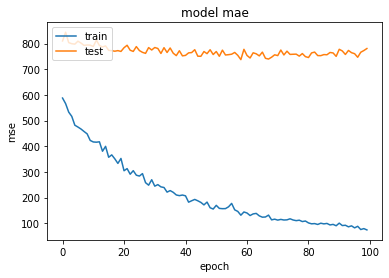

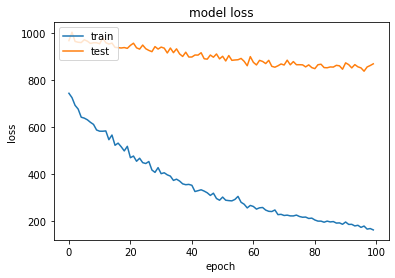

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model mae')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [38]:
score = model.evaluate(x=[X1_test, X2_test, X3_test, X4_test], y=y_test, verbose=1)
print(score)
print("Test Score:", score[0])
print("Test MSE:", score[1])
#print("Test MAE: ", score[2])

395/395 [==============================] - 0s 129us/sample - loss: 568.3972 - mse: 481.1827 - mae: 14.3724 - mape: 2304620032.0000
[568.3971605518196, 481.1827, 14.372351, 2304620000.0]
Test Score: 568.3971605518196
Test MSE: 481.1827


In [ ]:
#18개월
#